* [About this Dataset](#about)
* [EDA](#eda)
* [Data preparation](#dataprep)
* [Modeling](#modeling)
    * [Meta Learners](#metalearners)
        * [T-Learners](#tlearners)
        * [S-Learners](#slearners)
    * [Uplift Trees](#utrees)
* [Conclusions](#conclusions)

# About this Dataset <a class="anchor" id="about"></a>

  The dataset was created by The Criteo AI Lab .The dataset consists of 13M rows, each one representing a user with 12 features, a treatment indicator and 2 binary labels (visits and conversions). Positive labels mean the user visited/converted on the advertiser website during the test period (2 weeks). The global treatment ratio is 84.6%. It is usual that advertisers keep only a small control population as it costs them in potential revenue.  
  
Following is a detailed description of the features:  
  
- f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11: feature values (dense, float)
- treatment: treatment group (1 = treated, 0 = control)
- conversion: whether a conversion occured for this user (binary, label)
- visit: whether a visit occured for this user (binary, label)
- exposure: treatment effect, whether the user has been effectively exposed (binary)

In [1]:
!pip install causalml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 24.5 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.7/278.7 kB 20.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 55.3 MB/s eta 0:00:00
  Created wheel for causalml: filename=causalml-0.15.2-cp37-cp37m-linux_x86_64.whl size=6428252 sha256=2fb5a4989261f581f908c9b96a0728de1d29e81af238e63d3bd36f144bd833be
  Stored in directory: /root/.cache/pip/wheels/77/7b/df/ae934d53609fe0cd61502f11c72ed039222b98e08cdebe2a06
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24575 sha256=6fac6380e5af7be38b62bc19b0588811e481bfb5e82a4720df885f74f914d027
  Stored in directory: /root/.cache/pip/wheels/1e/7b/04/7387cf6cc9e48b4a96e361b0be812f0708b394b821bf8c9c50
Successfully built causalml pydotplus


In [2]:
!pip install scikit-uplift


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 2.9 MB/s eta 0:00:00


In [3]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklift.metrics import uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel, TwoModels
from sklearn.base import clone
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from causalml.inference.tree import UpliftRandomForestClassifier, UpliftTreeClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot
from IPython.display import Image

In [5]:
print("helk")

helk


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import shap
def prepare_data(df, feature_cols, treatment_col='treatment', target_col='conversion', 
                 test_size=0.2, random_state=42):
    """
    Prepares data for uplift modeling with binary treatment/control setup
    """
    # Split data into features, treatment and target
    X = df[feature_cols]
    y = df[target_col]
    t = df[treatment_col]

    # Train-test split with stratification on treatment
    X_train, X_test, t_train, t_test, y_train, y_test = train_test_split(
        X, t, y, test_size=test_size, random_state=random_state, stratify=t
    )

    return {
        't_train': t_train, 't_test': t_test,'X_train': X_train, 'X_test': X_test,'y_train': y_train, 'y_test': y_test
    }

# Example usage
feature_cols = [f'f{i}' for i in range(12)]
df = pd.read_csv('../input/uplift-modeling/criteo-uplift-v2.1.csv')
data = prepare_data(df, feature_cols)

# Access prepared data
X_train = data['X_train']
X_test = data['X_test']
t_train = data['t_train']
t_test = data['t_test']
y_train = data['y_train']
y_test = data['y_test']


In [6]:
from causalml.inference.meta import BaseSRegressor
from causalml.inference.tree import UpliftRandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor


# Initialize and train S-Learner
learner_s = BaseSRegressor(learner=XGBRegressor(random_state=42))
learner_s_result = learner_s.fit_predict(X=X_train, treatment=t_train, y=y_train)

print(learner_s_result)


[[8.54994287e-05]
 [1.00145233e-04]
 [3.63811385e-03]
 ...
 [1.30322325e-04]
 [8.54995669e-05]
 [1.00145233e-04]]


In [7]:
# from sklearn.utils.validation import check_is_fitted
# check_is_fitted(learner_s.model)


NotFittedError: This XGBRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [9]:
# print(type(learner_s.model_tau))  # should be XGBRegressor
# from sklearn.utils.validation import check_is_fitted
# check_is_fitted(learner_s.model_tau)


AttributeError: 'BaseSRegressor' object has no attribute 'model_tau'

In [10]:
print(type(learner_s.model))


<class 'xgboost.sklearn.XGBRegressor'>


In [11]:
# from sklearn.utils.validation import check_is_fitted
# check_is_fitted(learner_s.model)  # This should now pass ✅



NotFittedError: This XGBRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [12]:
    import shap
    
    # 1) Summarize your huge train set into 100 k‑means prototypes
    background = shap.kmeans(X_train, 100)
    
    # 2) Pick 1,000 rows to explain
    X_explain = X_test.sample(n=1000, random_state=42)
    


NameError: name 'tau_model' is not defined

In [2]:
tau_model = learner_s.models[1]  # Key is 1, not 'slearner'

# Now create the SHAP explainer
explainer = shap.TreeExplainer(
    tau_model,
    data=background,
    feature_perturbation="interventional"
)

# Compute SHAP values
shap_values = explainer.shap_values(X_explain)

# Plot summary
shap.summary_plot(shap_values, X_explain, feature_names=feature_cols)

NameError: name 'learner_s' is not defined

In [1]:
# Get SHAP values for your sampled users
shap_values = explainer.shap_values(X_explain)

# Create detailed contribution DataFrame using feature_cols
user_attributions = pd.DataFrame(
    data=shap_values,
    columns=[f"shap_{col}" for col in feature_cols],
    index=X_explain.index
)

# Add metadata columns
user_attributions = user_attributions.assign(
    baseline_prob=explainer.expected_value,
    predicted_prob=tau_model.predict(X_explain),
    actual_conversion=y_test.loc[X_explain.index].values if 'conversion' in df.columns else None
)

# Convert SHAP values to percentage contributions
shap_abs = np.abs(shap_values)
user_attributions_pct = shap_abs / shap_abs.sum(axis=1)[:, np.newaxis]

# Add percentage contribution columns using feature_cols
for i, col in enumerate(feature_cols):
    user_attributions[f"pct_{col}"] = user_attributions_pct[:, i]

# Add directional impact labels
for col in feature_cols:
    user_attributions[f"direction_{col}"] = np.where(
        user_attributions[f"shap_{col}"] > 0,
        "positive",
        "negative"
    )

# Reorganize columns
columns_order = ['baseline_prob', 'predicted_prob']
if 'actual_conversion' in user_attributions:
    columns_order.append('actual_conversion')
    
for col in feature_cols:
    columns_order.extend([
        f"shap_{col}",
        f"pct_{col}",
        f"direction_{col}"
    ])

user_attributions = user_attributions[columns_order]

# Save to CSV
user_attributions.to_csv('user_purchase_decision_contributions.csv')

# Example output for one user
sample_user = user_attributions.iloc[0]
print(f"\nPurchase Decision Breakdown for User {sample_user.name}")
print(f"Baseline Conversion Probability: {sample_user.baseline_prob:.2%}")
print(f"Predicted Conversion Probability: {sample_user.predicted_prob:.2%}")
if 'actual_conversion' in sample_user:
    print(f"Actual Conversion: {'Yes' if sample_user.actual_conversion else 'No'}")

print("\nFeature Contributions:")
for col in feature_cols:
    shap_val = sample_user[f"shap_{col}"]
    pct = sample_user[f"pct_{col}"]
    direction = sample_user[f"direction_{col}"]
    
    if abs(shap_val) > 0.001:  # Filter trivial impacts
        print(f"- {col}:")
        print(f"  Contribution: {shap_val:.4f} ({direction})")
        print(f"  Relative Impact: {pct:.1%}")

NameError: name 'explainer' is not defined

In [18]:
# import shap

# background = X_train.sample(n=100, random_state=42)




In [19]:
# # This gets the trained XGBRegressor (on treatment + features)
# tau_model = learner_s.model  # or learner_s.learner depending on causalml version


In [24]:
# import shap

# tau_model = learner_s.model  # this is your trained XGBRegressor

# background = X_train.sample(n=100, random_state=42)  # summarization for SHAP

# explainer = shap.TreeExplainer(tau_model, data=background, feature_perturbation="interventional")
# shap_values = explainer.shap_values(X_explain)

# shap.summary_plot(shap_values, X_explain, feature_names=feature_cols)


NotFittedError: need to call fit or load_model beforehand

In [20]:
# explainer = shap.TreeExplainer(
#     tau_model,
#     data=background,
#     feature_perturbation="interventional"
# )


NotFittedError: need to call fit or load_model beforehand

In [15]:
# # 2) Pick fewer rows for explanation
# X_explain = X_test.sample(300, random_state=42)

# # 3) Enable approximate mode to speed up TreeExplainer
# explainer = shap.TreeExplainer(
#     learner_s,
#     data=background,
#     feature_perturbation="interventional",
#     approximate=True
# )



Exception: Unsupported masker type: <class 'shap.utils._legacy.DenseData'>!

In [13]:

# # 4) Compute SHAP values
# shap_values = explainer.shap_values(X_explain)

# # 5) Plot summary
# shap.summary_plot(shap_values, X_explain, feature_names=feature_cols)

NameError: name 'explainer' is not defined

In [31]:
# # Suppose your treatments are 0 and 1
# for t_val, mdl in learner_s.models.items():
#     print(f"Booster for treatment={t_val}:", mdl.get_booster())


Booster for treatment=1: <xgboost.core.Booster object at 0x78f4d849afd0>


In [32]:
# # 'weight' is the number of times a feature appears in a split
# importance = booster.get_score(importance_type='weight')
# print(importance)


{'f0': 119.0, 'f1': 545.0, 'f2': 237.0, 'f3': 578.0, 'f4': 401.0, 'f5': 808.0, 'f6': 287.0, 'f7': 298.0, 'f8': 319.0, 'f9': 272.0, 'f10': 425.0, 'f11': 565.0, 'f12': 477.0}


In [40]:
# print(learner_s.model)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=42,
             reg_alpha=None, reg_lambda=None, ...)


In [41]:
# import numpy as np
# import pandas as pd
# import shap

# # --- assume learner_s is already fitted via fit_predict() ---
# #   and that X is your full feature DataFrame

# # 1. Grab the two fitted base models
# model_c = learner_s.models[0]   # control
# model_t = learner_s.models[1]   # treated

# # 2. Full‐data predictions & ITE point estimates
# pred_c = model_c.predict(X)
# pred_t = model_t.predict(X)
# ite_pred = pred_t - pred_c

# df_ite = pd.DataFrame({
#     'pred_control': pred_c,
#     'pred_treated': pred_t,
#     'ite_pred': ite_pred
# }, index=X.index)

# # 3. Sample ~10 000 users for SHAP
# sample_size = min(10_000, len(X))
# sample_idx = np.random.choice(X.index, size=sample_size, replace=False)
# X_sample = X.loc[sample_idx]

# # 4. Build TreeExplainers on the raw boosters
# booster_c = model_c.get_booster()
# booster_t = model_t.get_booster()
# expl_c   = shap.TreeExplainer(booster_c)
# expl_t   = shap.TreeExplainer(booster_t)

# # 5. Compute SHAP values on the sample
# shap_c = expl_c.shap_values(X_sample)   # (sample_size, n_features)
# shap_t = expl_t.shap_values(X_sample)   # same shape

# # 6. Compute per‐feature contribution to uplift = difference of SHAPs
# ite_shap = shap_t - shap_c              # (sample_size, n_features)
# shap_cols = [f"ΔSHAP_{col}" for col in X.columns]
# df_shap_sample = pd.DataFrame(ite_shap, columns=shap_cols, index=sample_idx)

# # 7. Map those sample‐level contributions back to full cohort
# #    (off‐sample rows will be NaN)
# df_shap_all = pd.DataFrame(index=X.index, columns=shap_cols)
# df_shap_all.loc[sample_idx] = df_shap_sample

# # 8. Combine predictions + contributions
# df_result = pd.concat([df_ite, df_shap_all], axis=1)

# # — now:
# # df_result.loc[user_id, 'ite_pred']          → ITE estimate for that user
# # df_result.loc[user_id, shap_cols]           → feature‐level ITE contributions (or NaN)
# # df_result.sample(5)                         → peek at 5 random users


KeyError: 0

In [42]:
print("Available treatment groups:", learner_s.t_groups)
print("Keys in learner_s.models:", learner_s.models.keys())



Available treatment groups: [1]
Keys in learner_s.models: dict_keys([1])


In [35]:
# import numpy as np
# print("Unique treatments in t_train:", np.unique(t_train))
# print("Counts:\n", pd.Series(t_train).value_counts())


Unique treatments in t_train: [0 1]
Counts:
 1    9506123
0    1677550
Name: treatment, dtype: int64


In [38]:
# from causalml.inference.meta import BaseSRegressor
# from xgboost import XGBRegressor

# # Recreate the S-learner and explicitly fit it
# learner_s = BaseSRegressor(learner=XGBRegressor(random_state=42))
# learner_s.fit(X=X_train, treatment=t_train, y=y_train)

# # Now it’s safe to access the fitted model
# model = learner_s.model

In [43]:
# import numpy as np
# import pandas as pd
# import shap
# import matplotlib.pyplot as plt

# # 1. Access the trained model (only treatment=1 exists in .models because BaseSRegressor uses one model with treatment as feature)
# model = learner_s.model  # This is your XGBRegressor

# # 2. Compute ITEs on full data
# X_np = X_train.values if hasattr(X_train, "values") else X_train
# n, p = X_np.shape

# # Create copies of X with treatment=0 and treatment=1 as first column
# X_control = np.hstack((np.zeros((n, 1)), X_np))
# X_treat   = np.hstack((np.ones((n, 1)),  X_np))

# # Predict outcomes
# pred_c   = model.predict(X_control)
# pred_t   = model.predict(X_treat)
# ite_pred = pred_t - pred_c

# # Create DataFrame with ITE
# df_result = pd.DataFrame({
#     "pred_control": pred_c,
#     "pred_treated": pred_t,
#     "ite_pred":     ite_pred
# }, index=X_train.index)

# # 3. SHAP value estimation on a small sample
# sample_size = 10000  # You can adjust this
# sample_idx = np.random.choice(X_train.index, size=sample_size, replace=False)
# X_samp = X_train.loc[sample_idx]

# # Add treatment column to features
# Xt_samp = np.hstack((np.ones((sample_size, 1)), X_samp.values))  # treatment = 1
# Xc_samp = np.hstack((np.zeros((sample_size, 1)), X_samp.values)) # treatment = 0

# # Create SHAP explainer
# explainer = shap.TreeExplainer(model)

# # Compute SHAP values for treatment=1 and treatment=0
# shap_treated = explainer.shap_values(Xt_samp)
# shap_control = explainer.shap_values(Xc_samp)

# # Compute SHAP uplift (difference in contribution)
# shap_uplift = shap_treated - shap_control

# # Create SHAP DataFrame for the sample
# shap_df = pd.DataFrame(shap_uplift, columns=X_train.columns, index=X_samp.index)
# shap_df["ite_pred_sample"] = ite_pred[sample_idx]

# # 4. Summary plot of feature contributions to ITE
# shap.summary_plot(shap_uplift, features=X_samp, feature_names=X_train.columns, show=True)


NotFittedError: need to call fit or load_model beforehand

In [44]:
# fitted_model = learner_s.models['slearner']
# print(fitted_model.get_booster())  


KeyError: 'slearner'

In [20]:
# # This will explicitly fit your S-learner model (XGBoost inside)
# learner_s.fit(X=X_train, treatment=t_train, y=y_train)


In [59]:
print(learner_s.model)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=42,
             reg_alpha=None, reg_lambda=None, ...)


In [24]:
# fitted_model = learner_s.model
# print(fitted_model.get_booster())


NotFittedError: need to call fit or load_model beforehand

In [45]:
print(dir(learner_s))

['__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_classes', '_format_p', '_set_propensity_models', 'ate_alpha', 'bootstrap', 'control_name', 'estimate_ate', 'fit', 'fit_predict', 'get_importance', 'get_shap_values', 'model', 'models', 'plot_importance', 'plot_shap_dependence', 'plot_shap_values', 'predict', 't_groups']


In [26]:
print(dir(learner_s))

['__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_classes', '_format_p', '_set_propensity_models', 'ate_alpha', 'bootstrap', 'control_name', 'estimate_ate', 'fit', 'fit_predict', 'get_importance', 'get_shap_values', 'model', 'models', 'plot_importance', 'plot_shap_dependence', 'plot_shap_values', 'predict', 't_groups']


In [46]:
print(type(learner_s.model))

<class 'xgboost.sklearn.XGBRegressor'>


In [13]:
# fitted_model = learner_s.model
# print(fitted_model.get_booster())

NotFittedError: need to call fit or load_model beforehand

In [47]:
print(learner_s_result.shape)

(11183673, 1)


In [48]:
result=learner_s.get_importance(X=X_train, tau=learner_s_result, normalize=True, method='auto', features=feature_cols)
result

{1: f4     0.446077
 f3     0.194586
 f11    0.087215
 f9     0.065065
 f0     0.056892
 f2     0.044279
 f10    0.037780
 f6     0.028997
 f8     0.013343
 f5     0.010116
 f7     0.008173
 f1     0.007478
 dtype: float64}

In [49]:
print(learner_s.models)

{1: XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)}


In [16]:
print(type(learner_s.model))  # Inspect the type

<class 'xgboost.sklearn.XGBRegressor'>


In [50]:
# fitted_model = learner_s.model
# print(fitted_model.get_booster())


NotFittedError: need to call fit or load_model beforehand

In [ ]:
# from xgboost import XGBRegressor

# # Create your own XGBRegressor
# xgb_model = XGBRegressor(random_state=42)

# # Create treatment indicator feature
# X_augmented = X_train.copy()
# X_augmented['treatment'] = t_train

# # Fit the model directly on augmented X and original y
# xgb_model.fit(X_augmented, y_train)

In [60]:
# learner_s.fit(X=X_train, treatment=t_train, y=y_train)

# # Verify that the model has been fitted
# print(learner_s.model.get_booster())


NotFittedError: need to call fit or load_model beforehand

In [62]:
# from sklearn.utils.validation import check_is_fitted

# check_is_fitted(learner_s.model)


NotFittedError: This XGBRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [61]:
# print(learner_s.model.get_booster())

NotFittedError: need to call fit or load_model beforehand

In [51]:
pip install --upgrade shap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 545.7/545.7 kB 18.1 MB/s eta 0:00:00
  Attempting uninstall: shap
    Found existing installation: shap 0.40.0
    Uninstalling shap-0.40.0:
      Successfully uninstalled shap-0.40.0
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# import shap

# # Now this will work as the model is properly fitted
# explainer = shap.TreeExplainer(xgb_model)
# shap_values = explainer.shap_values(X_augmented)

# # Visualize feature impact
# shap.summary_plot(shap_values, X_augmented, feature_names=X_augmented.columns)


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [58]:
# import shap

# # Define your feature columns
# feature_cols = [f'f{i}' for i in range(12)]

# # Sample from the original dataset
# X_sampled = df[feature_cols].sample(n=1000, random_state=42)

# # Use TreeExplainer for tree-based models like XGBoost
# explainer = shap.TreeExplainer(learner_s.model)

# # Compute SHAP values
# shap_values = explainer.shap_values(X_sampled)

# # Summary plot
# shap.summary_plot(shap_values, X_sampled, feature_names=feature_cols)


NotFittedError: need to call fit or load_model beforehand

In [52]:
# # Create a per-user SHAP DataFrame
# import pandas as pd

# shap_df = pd.DataFrame(shap_values, columns=X_augmented.columns)
# shap_df['predicted_uplift'] = xgb_model.predict(X_augmented)
# shap_df['user_id'] = X_augmented.index

# # See the top 5 users
# shap_df.head()


NameError: name 'shap_values' is not defined

In [ ]:
# # Top k features driving the prediction per user
# shap_df['top_k_features'] = shap_df[X_augmented.columns].abs().apply(
#     lambda row: row.nlargest(4).index.tolist(), axis=1
# )


In [ ]:
# import shap
# import pandas as pd

# # Step 1: Create a SHAP TreeExplainer
# explainer = shap.TreeExplainer(xgb_model)

# # Step 2: Compute SHAP values for each user (row) and feature
# shap_values = explainer.shap_values(X_augmented)

# # Step 3: Convert to DataFrame
# shap_df = pd.DataFrame(shap_values, columns=X_augmented.columns)

# # Step 4: Add predicted uplift as a separate column
# shap_df['predicted_uplift'] = xgb_model.predict(X_augmented)

# # Step 5: Add unique IDs if not already present
# shap_df['user_id'] = X_augmented.index

# # Optional: Reorder columns
# shap_df = shap_df[['user_id', 'predicted_uplift'] + list(X_augmented.columns)]

# # Step 6: View the SHAP contributions for each user
# print(shap_df.head())


In [ ]:
# import shap

# # Use the fitted XGBoost model directly
# fitted_model = learner_s.model

# # SHAP TreeExplainer
# explainer = shap.TreeExplainer(fitted_model)

# # Get SHAP values (this gives you the effect of each feature on the model's prediction)
# shap_values = explainer.shap_values(X_train)

# # Summary plot to visualize feature impact on the treatment effect
# shap.summary_plot(shap_values, X_train, feature_names=feature_cols)


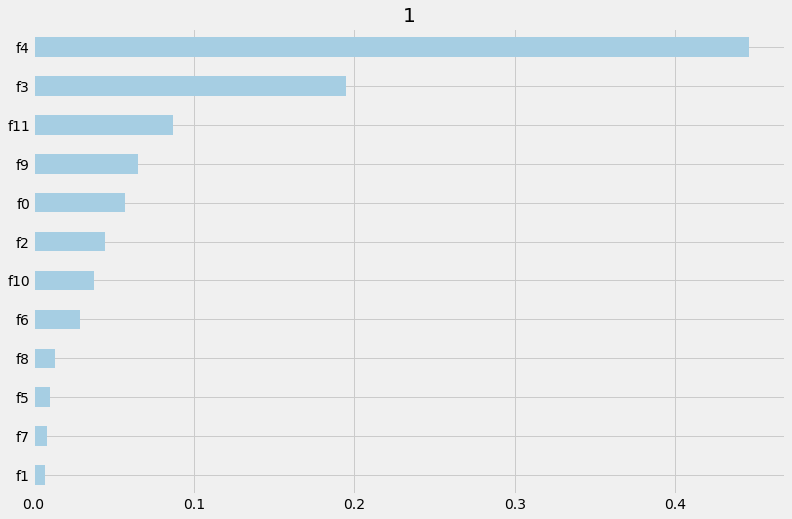

In [29]:
learner_s.plot_importance(X=X_train, tau=learner_s_result, normalize=True, method='auto', features=feature_cols)


In [ ]:
# from sklearn.neural_network import MLPRegressor
# from causalml.inference.meta import BaseSRegressor

# # Define the neural network regressor
# nn = MLPRegressor(hidden_layer_sizes=(35, 25, 10, 5),
#                   learning_rate_init=0.01,
#                   early_stopping=True,
#                   random_state=1)

In [ ]:
# from sklearn.neural_network import MLPRegressor
# from causalml.inference.meta import BaseSRegressor

# # Define your neural network estimator
# nn = MLPRegressor(hidden_layer_sizes=(35, 25, 10, 5),
#                   learning_rate_init=0.01,
#                   early_stopping=True,
#                   random_state=1)

# # Plug it into the S-Learner
# learner_s = BaseSRegressor(learner=nn)

# # Compute ITE estimates for each observation in X_train
# nn_ite = learner_s.fit_predict(X=X_train, treatment=t_train, y=y_train)

# # Print first few ITE estimates for inspection
# print("Estimated ITE via neural network S-Learner:")
# print(nn_ite[:5])


In [ ]:
# import pandas as pd
# from sklearn.inspection import permutation_importance
# from sklearn.neural_network import MLPRegressor
# from causalml.inference.meta import BaseSRegressor

# # # Define the neural network regressor
# # nn = MLPRegressor(hidden_layer_sizes=(35, 25, 10, 5),
# #                   learning_rate_init=0.01,
# #                   early_stopping=True,
# #                   random_state=1)

# # # Plug it into the S-Learner
# # learner_s = BaseSRegressor(learner=nn)
# # learner_s_result = learner_s.fit_predict(X=X_train, treatment=t_train, y=y_train)

# # Compute permutation feature importance on the neural network model
# # result = permutation_importance(nn, X_train, y_train, n_repeats=10, random_state=42)
# result = permutation_importance(learner_s.model, X_train, y_train, n_repeats=10, random_state=42)

# result


In [23]:
feature_results = result[1]
feature_results

f4     0.446077
f3     0.194586
f11    0.087215
f9     0.065065
f0     0.056892
f2     0.044279
f10    0.037780
f6     0.028997
f8     0.013343
f5     0.010116
f7     0.008173
f1     0.007478
dtype: float64

In [24]:
feature_results = feature_results/feature_results.sum() * 100
feature_results

f4     44.607747
f3     19.458561
f11     8.721534
f9      6.506494
f0      5.689237
f2      4.427859
f10     3.777985
f6      2.899658
f8      1.334262
f5      1.011587
f7      0.817313
f1      0.747763
dtype: float64

In [25]:
import pickle
# Save the entire model (including its weights) to a checkpoint file
checkpoint_filename = "synapses_checkpint.pkt"
with open(checkpoint_filename, "wb") as f:
    pickle.dump(nn, f)

print(f"Model checkpoint saved to {checkpoint_filename}")

Model checkpoint saved to synapses_checkpint.pkt


In [ ]:
# dir(nn)

Looks like the most effective uplift method for this dataset (from tested here) is uplift tree with overall uplift 0.03 (0.031 for top 30%). Among meta learners S-Learners perform better than T-Learners (with a S-Learner based on LGBMClassifier as a leader).